In [6]:
import cometspy as c
import cobra
import cobra.test
from cobra import Metabolite, Reaction
import pandas as pd
import os
os.environ['GUROBI_COMETS_HOME'] = '/opt/gurobi900/linux64'
pd.set_option('display.max_rows', None) 

In [22]:
from cometspy.comets import __version__ as v
v # this needs to be >= 0.4.16

'0.4.16'

## This notebook attempts a phage-like simulation

Some notes. 

One problem with this approach is that there is no way to check if the model is growing or not, and tying death or phage production to that. This means phage production will occur as long as the model is feasible (i.e. there is a flux-balance analysis solution) and death will occur no matter what, even when growth has ceased. It would be possible to modify COMETS to cease the activity of the phage when growth of the model has ceased, and relatively straightforward I think, but it is not currently possible.

With that in mind, below is as close as I think is possible at the moment. I will use the textbook ecoli model for it. Note that if you are using a more recent version of cobra, it is loaded different (with cobra.io.load_model("textbook"). 

To the textbook model, we'll add three reactions: 

1. a reaction that, at very low cost, produces phage. Right now I have this made from ATP. A cost-less alternative could make phage from water. I tried using a "demand" reaction but was getting unexpected behavior (no phage production when there should have been). I think that's a solvable problem without coding COMETS, but it was faster to just switch to this for now.phage exchange reaction, and a phage producing reaction. 
2. a transport reaction which converts cytoplasmic phage (phage_c) to extracellular phage (phage_e). 
3. an exchange reaction to secrete phage_e.

The way this will work is that when we make the COMETS model, we'll use two different signals. 
1. Extracellular phage will turn up the lower bound on phage production. In the below example this will be with a linear effect, but bounded linear (aka with a "lag" and a "max") or an S-curve (using "generalized logistic") are also possible.
2. A second "death" signal will increase the death rate in linear proportion to extracellular phage. 


In [7]:
tb = cobra.test.create_test_model("textbook")

Using license file /home/jeremy/gurobi.lic
Academic license - for non-commercial use only


In [8]:
tb.summary()

In [9]:
# here we edit the cobra model first, adding in the three reactions.
# I am setting the phage cost to be quite low--too high, and it causes the model to be infeasible

phage_cost = 1.e-6

phage_e = Metabolite("phage_e", compartment = "e")
phage_c = Metabolite("phage_c", compartment = "c")
atp_c = tb.metabolites.atp_c
adp_c = tb.metabolites.adp_c
phage_prod = Reaction("phage_prod", lower_bound = 0, upper_bound = 1000)
phage_prod.add_metabolites({atp_c: -phage_cost,
                           adp_c: phage_cost,
                           phage_c: 1})
phage_t = Reaction("phage_t", lower_bound = 0, upper_bound = 1000)
phage_t.add_metabolites({phage_c: -1,
                       phage_e: 1})
# add_boundary is the preferred way to have unbalanced reactions
tb.add_boundary(phage_e, type = "exchange", lb = 0, ub = 1000)
# add_reactions is useful for any other type of reaction
tb.add_reactions([phage_prod, phage_t])

In [10]:
# make the comets model from the modified textbook model
m = c.model(tb)

In [11]:
m.reactions # note that EX_phage_e is an exchange, with exch_ind 21, and phage_prod is id = 97

,REACTION_NAMES,ID,LB,UB,EXCH,EXCH_IND,V_MAX,KM,HILL
0,ACALD,1,-1000.00,1000.0,False,0,NaN,NaN,NaN
1,ACALDt,2,-1000.00,1000.0,False,0,NaN,NaN,NaN
2,ACKr,3,-1000.00,1000.0,False,0,NaN,NaN,NaN
3,ACONTa,4,-1000.00,1000.0,False,0,NaN,NaN,NaN
4,ACONTb,5,-1000.00,1000.0,False,0,NaN,NaN,NaN
5,ACt2r,6,-1000.00,1000.0,False,0,NaN,NaN,NaN
6,ADK1,7,-1000.00,1000.0,False,0,NaN,NaN,NaN
7,AKGDH,8,0.00,1000.0,False,0,NaN,NaN,NaN
8,AKGt2r,9,-1000.00,1000.0,False,0,NaN,NaN,NaN
9,ALCD2x,10,-1000.00,1000.0,False,0,NaN,NaN,NaN


In [12]:
# any python function that was written with a "signature" can be shown using help. 
#This works for all cometspy functions, and also cobra's functions
help(m.add_signal)

Help on method add_signal in module cometspy.model:

add_signal(rxn_num, exch_id, bound, function, parms) method of cometspy.model.model instance
    adds a signal to the reaction rxn_num that changes bounds
    
    Parameters
    ----------
    rxn_num : int or 'death'
        reaction affected (int) or whether the signal causes death 'death'
    exch_id : int
        the number of the exchange reaction. see model.metabolites
    bound : str  'ub' or 'lb'
        specifies whether the upper or lower bound is affected
    function : str 'linear' or 'bounded_linear' or 'generalized_logistic'
        specifies the function relating the metabolite conc. to the bound
    parms : list (float)
        a list of floats for the function



# first have phage cause more phage propagation.

This uses a signal which turns up phage_prod in response to the concentration of phage.

Note that phage concentration, like any metabolite concentration, is a function of both the mmol present, as well as the volume of the experimental box. 

In COMETS, a box' volume is the spaceWidth ^3, in cm^3. Below, we will do a 1 L (== 1000cm^3) simulation. If we start with 1 "mmol" phage, then the initial concentration is 1 mmol / (1000cm3) = 0.001 M.  

Signals work in molar units. I assume an intercept of zero, since phage shouldn't be made unless there are phage extracellularly.  So if we want the lower bound on phage production to be 1 mmol/gDW/hr initially, with the 1 mmol phage and 1000cm3 box volume, a slope of 1000 is needed. 

In [15]:
m = c.model(tb) # I am remaking this fresh each time just because its easier to iterate through diff parameter values without running lots of chunks
a = 1000 # a = slope. 
b = 0 # b = intercept

phage_prod_rxn_num = m.reactions.ID[m.reactions.REACTION_NAMES == "phage_prod"].values[0]
phage_exch_num = m.reactions.EXCH_IND[m.reactions.REACTION_NAMES == "EX_phage_e"].values[0]

m.add_signal(phage_prod_rxn_num,
             phage_exch_num,
             bound = "lb",
             function = "linear",
             parms = [a, b])


In [16]:
m.signals

,REACTION_NUMBER,EXCH_IND,BOUND,FUNCTION,PARAMETERS,REACTION_NAMES,EXCH
0,97,21,lb,linear,"[1000, 0]",phage_prod,phage_e


# Now if we run a simulation, we should see the flux increasing from a baseline of 1, and we should see the amount of phage in the environment also increase. Here we save media and flux logs to be able to examine that.

In [17]:
m.initial_pop = [0, 0, 1.e-2]
m.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"

p = c.params()
p.set_param("timeStep", 0.1) # hours
p.set_param("maxCycles", round(24 / 0.1))
p.set_param("writeFluxLog", True)
p.set_param("FluxLogRate", 1)
p.set_param("writeMediaLog", True)
p.set_param("MediaLogRate", 1)
p.set_param("maxSpaceBiomass", 20)
p.set_param("spaceWidth", 10) # 1 L
p.set_param("defaultKm", 0.00001)

l = c.layout([m])
l.set_specific_metabolite("o2_e", 1000)
l.set_specific_metabolite("pi_e", 1000)
l.set_specific_metabolite("nh4_e", 1000)
l.set_specific_metabolite("glc__D_e", 5)
l.set_specific_metabolite("phage_e", 1) # start with 1 "mmol" of phage

## Note: the COMETS version shipped with is not fully up-to-date with signaling (it is present,but has a few bugs). Hence why a different version, and version location, is specifed below.

In [23]:
sim = c.comets(l, p)
sim.VERSION = 'comets_multitoxin.jar'
sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_multitoxin.jar')

In [24]:
sim.run()


Running COMETS simulation ...
Done!


<AxesSubplot:xlabel='cycle'>

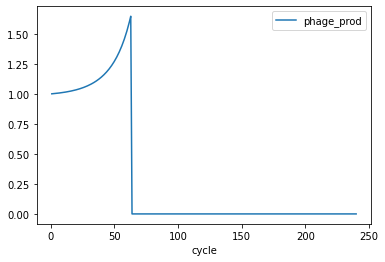

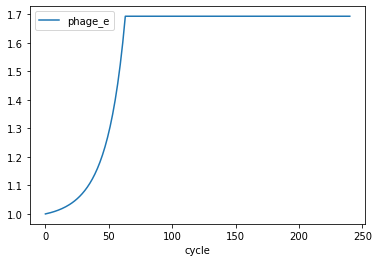

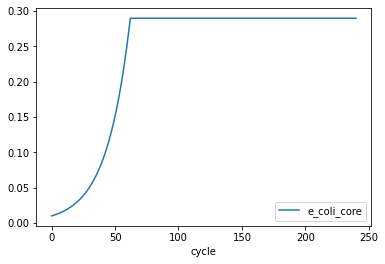

In [25]:
sim.fluxes_by_species["e_coli_core"].loc[:, ["phage_prod","cycle"]].plot(x = "cycle", y = "phage_prod")
sim.media.loc[sim.media.metabolite == "phage_e", :].plot(x = "cycle", y = "conc_mmol", label = "phage_e")
sim.total_biomass.plot(x = "cycle")

# death

next, we also want the phage to kill the bacteria. lets have the phage get "consumed" during this process,sort of like how phage must die to reproduce. 


Running COMETS simulation ...
Done!


<AxesSubplot:xlabel='cycle'>

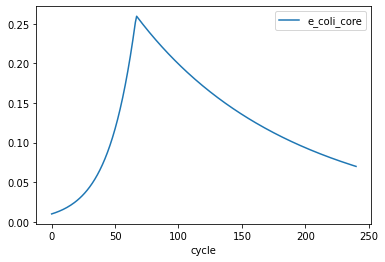

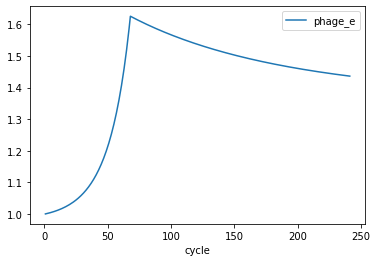

In [26]:
# we'll remake the model, 
m = c.model(tb)
m.initial_pop = [0, 0, 1.e-2]
m.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"
a = 1000 # slope
b = 0

phage_prod_rxn_num = m.reactions.ID[m.reactions.REACTION_NAMES == "phage_prod"].values[0]
phage_exch_num = m.reactions.EXCH_IND[m.reactions.REACTION_NAMES == "EX_phage_e"].values[0]

m.add_signal(phage_prod_rxn_num,
             phage_exch_num,
             bound = "lb",
             function = "linear",
             parms = [a, b])

# note that the parameter values for death here are quite finicky
m.add_signal("death", phage_exch_num, "consume_met", "linear", [50, 0])

l = c.layout([m])
l.set_specific_metabolite("o2_e", 1000)
l.set_specific_metabolite("pi_e", 1000)
l.set_specific_metabolite("nh4_e", 1000)
l.set_specific_metabolite("glc__D_e", 5)
l.set_specific_metabolite("phage_e", 1)

sim = c.comets(l, p)
sim.VERSION = 'signal_dev.jar'
sim.set_classpath('bin', '/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/signal_dev.jar')
sim.run()
sim.total_biomass.plot(x = "cycle")
sim.media.loc[sim.media.metabolite == "phage_e", :].plot(x = "cycle", y = "conc_mmol", label = "phage_e")